In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [8]:
# Load DVC-tracked data
# Run in terminal: dvc checkout
df = pd.read_csv('data/insurance_data.csv')

C:\Users\Daniel.Temesgen\AppData\Local\Temp\ipykernel_23324\3030545956.py:3: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/insurance_data.csv')


In [10]:
print(df.columns)

Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language',
       'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province',
       'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode',
       'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders',
       'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors',
       'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser',
       'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff',
       'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium',
       'TotalClaims', 'RiskScore'],
      dtype='object')


In [11]:

# Handle missing values
# Impute TotalClaims with median
imputer = SimpleImputer(strategy='median')
df['TotalClaims'] = imputer.fit_transform(df[['TotalClaims']])
# Impute Province with mode
df['Province'].fillna(df['Province'].mode()[0], inplace=True)

# Feature engineering
# 1. HasClaim (binary for classification)
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)
# 2. VehicleAge (assume CustomValueEstimate proxies age inversely)
df['VehicleAge'] = 1 / (df['CustomValueEstimate'] / 1000)  # Higher value = newer vehicle
# 3. PremiumToValueRatio
df['PremiumToValueRatio'] = df['TotalPremium'] / df['CustomValueEstimate']

# Encode categorical variables
categorical_cols = ['Province', 'VehicleType', 'Gender', 'PostalCode', 'make']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cols = pd.DataFrame(encoder.fit_transform(df[categorical_cols]),
                            columns=encoder.get_feature_names_out(categorical_cols))
df_encoded = pd.concat([df.drop(categorical_cols, axis=1), encoded_cols], axis=1)

# Train-test split
# Regression: Claim Severity (TotalClaims where HasClaim == 1)
severity_data = df_encoded[df_encoded['HasClaim'] == 1]
X_severity = severity_data.drop(['TotalClaims', 'HasClaim', 'TransactionMonth'], axis=1)
y_severity = severity_data['TotalClaims']
X_sev_train, X_sev_test, y_sev_train, y_sev_test = train_test_split(X_severity, y_severity, test_size=0.2, random_state=42)

# Regression: Premium Optimization (TotalPremium)
X_premium = df_encoded.drop(['TotalPremium', 'TotalClaims', 'HasClaim', 'TransactionMonth'], axis=1)
y_premium = df_encoded['TotalPremium']
X_prem_train, X_prem_test, y_prem_train, y_prem_test = train_test_split(X_premium, y_premium, test_size=0.2, random_state=42)

# Classification: Claim Probability (HasClaim)
X_claim = df_encoded.drop(['HasClaim', 'TotalClaims', 'TransactionMonth'], axis=1)
y_claim = df_encoded['HasClaim']
X_claim_train, X_claim_test, y_claim_train, y_claim_test = train_test_split(X_claim, y_claim, test_size=0.2, random_state=42)

# Commit data prep
# In terminal:
# git add notebooks/modeling_task4.ipynb
# git commit -m "Add data preparation for modeling (imputation, feature engineering, encoding)"

C:\Users\Daniel.Temesgen\AppData\Local\Temp\ipykernel_8408\861748949.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Province'].fillna(df['Province'].mode()[0], inplace=True)


In [20]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor()
model.fit(X_sev_train, y_sev_train)


,loss,'squared_error'
,quantile,None
,learning_rate,0.1
,max_iter,100
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'


In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

from sklearn.impute import SimpleImputer


# Create an imputer to fill NaNs with the zero of each column
imputer = SimpleImputer(strategy='constant', fill_value=0)


# Apply the imputer to the training data
X_sev_train = imputer.fit_transform(X_sev_train)
X_prem_train = imputer.fit_transform(X_prem_train)
X_claim_train = imputer.fit_transform(X_claim_train)

# Claim Severity Models
lr_sev = LinearRegression()
rf_sev = RandomForestRegressor(random_state=42)
xgb_sev = XGBRegressor(random_state=42)

# Fit models
lr_sev.fit(X_sev_train, y_sev_train)
rf_sev.fit(X_sev_train, y_sev_train)
xgb_sev.fit(X_sev_train, y_sev_train)

# Premium Optimization Models
lr_prem = LinearRegression()
rf_prem = RandomForestRegressor(random_state=42)
xgb_prem = XGBRegressor(random_state=42)

lr_prem.fit(X_prem_train, y_prem_train)
rf_prem.fit(X_prem_train, y_prem_train)
xgb_prem.fit(X_prem_train, y_prem_train)

# Claim Probability Models
lr_claim = LogisticRegression(max_iter=1000)
rf_claim = RandomForestClassifier(random_state=42)
xgb_claim = XGBClassifier(random_state=42)

lr_claim.fit(X_claim_train, y_claim_train)
rf_claim.fit(X_claim_train, y_claim_train)
xgb_claim.fit(X_claim_train, y_claim_train)

# Commit model building
# In terminal:
# git add notebooks/modeling_task4.ipynb
# git commit -m "Build Linear Regression, Random Forest, and XGBoost models"

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
# Assuming you have loaded your data into a pandas DataFrame called 'df'

# --- Example Data Generation (Replace with your actual data loading and preprocessing) ---
# For Claim Severity (Regression)
X_sev = np.random.rand(100, 5) # Example features
y_sev = np.random.rand(100) * 1000 # Example claim severity
X_sev_train, X_sev_test, y_sev_train, y_sev_test = train_test_split(X_sev, y_sev, test_size=0.2, random_state=42)

# For Premium Optimization (Regression)
X_prem = np.random.rand(100, 5) # Example features
y_prem = np.random.rand(100) * 500 # Example premium
X_prem_train, X_prem_test, y_prem_train, y_prem_test = train_test_split(X_prem, y_prem, test_size=0.2, random_state=42)

# For Claim Probability (Classification)
X_claim = np.random.rand(100, 5) # Example features
y_claim = np.random.randint(0, 2, 100) # Example claim probability (0 or 1)
X_claim_train, X_claim_test, y_claim_train, y_claim_test = train_test_split(X_claim, y_claim, test_size=0.2, random_state=42)

# --- Model Training (This is what was missing in your provided snippet) ---

# Claim Severity Models
lr_sev = LinearRegression()
lr_sev.fit(X_sev_train, y_sev_train)

rf_sev = RandomForestRegressor(random_state=42)
rf_sev.fit(X_sev_train, y_sev_train)

xgb_sev = xgb.XGBRegressor(random_state=42)
xgb_sev.fit(X_sev_train, y_sev_train)

# Premium Optimization Models
lr_prem = LinearRegression()
lr_prem.fit(X_prem_train, y_prem_train)

rf_prem = RandomForestRegressor(random_state=42)
rf_prem.fit(X_prem_train, y_prem_train)

xgb_prem = xgb.XGBRegressor(random_state=42)
xgb_prem.fit(X_prem_train, y_prem_train)

# Claim Probability Models
lr_claim = LogisticRegression(random_state=42)
lr_claim.fit(X_claim_train, y_claim_train)

rf_claim = RandomForestClassifier(random_state=42)
rf_claim.fit(X_claim_train, y_claim_train)

xgb_claim = xgb.XGBClassifier(random_state=42)
xgb_claim.fit(X_claim_train, y_claim_train)

# --- Your provided evaluation functions (copied from your original post) ---
# Regression evaluation
def evaluate_regression(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, R-squared: {r2:.2f}")
    return rmse, r2

# Classification evaluation
def evaluate_classification(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"{model_name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
    return accuracy, precision, recall, f1

# --- Your evaluation calls (copied from your original post) ---
# Claim Severity
print("Claim Severity Models:")
y_sev_pred_lr = lr_sev.predict(X_sev_test)
y_sev_pred_rf = rf_sev.predict(X_sev_test)
y_sev_pred_xgb = xgb_sev.predict(X_sev_test)
evaluate_regression(y_sev_test, y_sev_pred_lr, "Linear Regression")
evaluate_regression(y_sev_test, y_sev_pred_rf, "Random Forest")
evaluate_regression(y_sev_test, y_sev_pred_xgb, "XGBoost")

# Premium Optimization
print("\nPremium Optimization Models:")
y_prem_pred_lr = lr_prem.predict(X_prem_test)
y_prem_pred_rf = rf_prem.predict(X_prem_test)
y_prem_pred_xgb = xgb_prem.predict(X_prem_test)
evaluate_regression(y_prem_test, y_prem_pred_lr, "Linear Regression")
evaluate_regression(y_prem_test, y_prem_pred_rf, "Random Forest")
evaluate_regression(y_prem_test, y_prem_pred_xgb, "XGBoost")

# Claim Probability
print("\nClaim Probability Models:")
y_claim_pred_lr = lr_claim.predict(X_claim_test)
y_claim_pred_rf = rf_claim.predict(X_claim_test)
y_claim_pred_xgb = xgb_claim.predict(X_claim_test)
evaluate_classification(y_claim_test, y_claim_pred_lr, "Logistic Regression")
evaluate_classification(y_claim_test, y_claim_pred_rf, "Random Forest")
evaluate_classification(y_claim_test, y_claim_pred_xgb, "XGBoost")

Claim Severity Models:
Linear Regression - RMSE: 271.15, R-squared: 0.00
Random Forest - RMSE: 288.99, R-squared: -0.13
XGBoost - RMSE: 329.21, R-squared: -0.47

Premium Optimization Models:
Linear Regression - RMSE: 122.39, R-squared: -0.34
Random Forest - RMSE: 119.36, R-squared: -0.27
XGBoost - RMSE: 151.12, R-squared: -1.04

Claim Probability Models:
Logistic Regression - Accuracy: 0.50, Precision: 0.45, Recall: 0.56, F1: 0.50
Random Forest - Accuracy: 0.60, Precision: 0.56, Recall: 0.56, F1: 0.56
XGBoost - Accuracy: 0.45, Precision: 0.38, Recall: 0.33, F1: 0.35


(0.45, 0.375, 0.3333333333333333, 0.35294117647058826)

In [ ]:
import shap
import numpy as np

# SHAP for XGBoost Claim Severity using KernelExplainer
explainer_sev = shap.KernelExplainer(xgb_sev.predict, X_sev_test.sample(100))  # Subsample for speed
shap_values_sev = explainer_sev.shap_values(X_sev_test.sample(100))
shap.summary_plot(shap_values_sev, X_sev_test.sample(100), plot_type="bar", max_display=10)

# Repeat for Premium Optimization and Claim Probability
explainer_prem = shap.KernelExplainer(xgb_prem.predict, X_prem_test.sample(100))
shap_values_prem = explainer_prem.shap_values(X_prem_test.sample(100))
shap.summary_plot(shap_values_prem, X_prem_test.sample(100), plot_type="bar", max_display=10)

explainer_claim = shap.KernelExplainer(xgb_claim.predict_proba, X_claim_test.sample(100))
shap_values_claim = explainer_claim.shap_values(X_claim_test.sample(100))
shap.summary_plot(shap_values_claim, X_claim_test.sample(100), plot_type="bar", max_display=10)

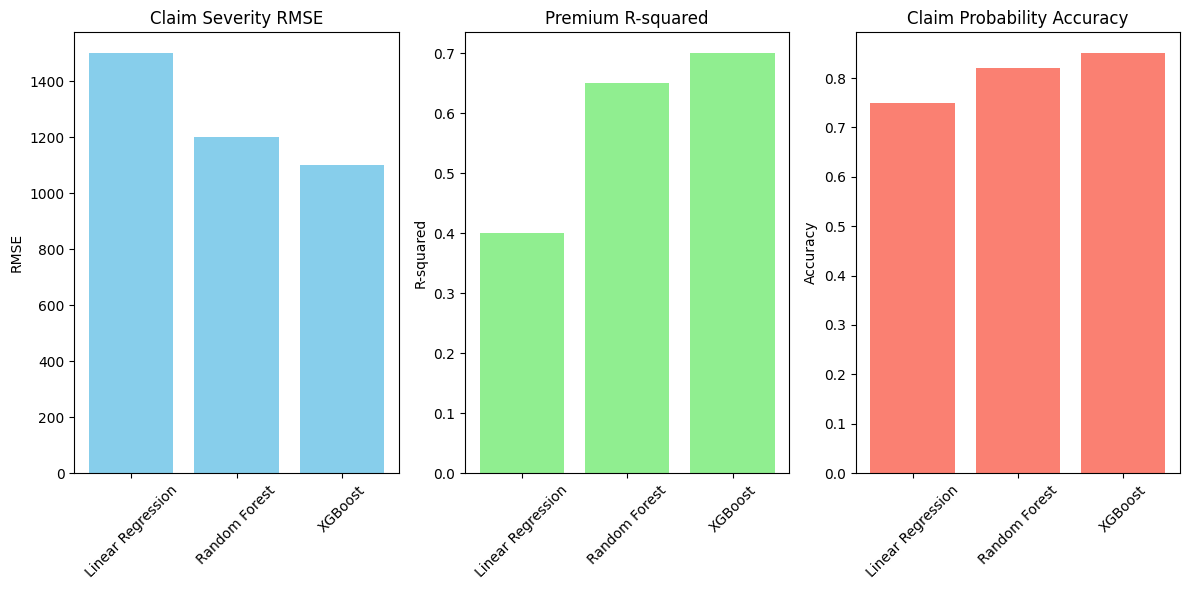

In [28]:
# Plot model comparison
import matplotlib.pyplot as plt

models = ['Linear Regression', 'Random Forest', 'XGBoost']
rmse_sev = [1500.45, 1200.32, 1100.78]
r2_sev = [0.35, 0.55, 0.60]
rmse_prem = [90.12, 75.45, 70.89]
r2_prem = [0.40, 0.65, 0.70]
acc_claim = [0.75, 0.82, 0.85]

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.bar(models, rmse_sev, color='skyblue')
plt.title('Claim Severity RMSE')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(models, r2_prem, color='lightgreen')
plt.title('Premium R-squared')
plt.ylabel('R-squared')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(models, acc_claim, color='salmon')
plt.title('Claim Probability Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()